### Required libraries

In [7]:
%pip install transformers torch torchaudio datasets pyaudio librosa soundfile sounddevice matplotlib

Note: you may need to restart the kernel to use updated packages.


## Step 1: Capture Voice Input

In [8]:
import sounddevice as sd
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt

# Audio Settings
SAMPLE_RATE = 16000  # Standard speech recognition sample rate
SILENCE_THRESHOLD = 0.01  # Silence detection threshold (adjustable)
SILENCE_DURATION = 2  # Stop recording if silence lasts this long (seconds)


In [9]:
def record_audio_until_silence(sample_rate=SAMPLE_RATE, silence_threshold=SILENCE_THRESHOLD, silence_duration=SILENCE_DURATION):
    print("🎤 Listening... Speak now (Stops when silent for 3 seconds)...")

    audio_buffer = []
    silence_start = None
    stream = sd.InputStream(samplerate=sample_rate, channels=1, dtype=np.float32)
    
    with stream:
        while True:
            # Read audio chunk
            audio_chunk, _ = stream.read(int(sample_rate * 0.1))  # 100ms chunks
            audio_buffer.append(audio_chunk)

            # Compute volume level
            volume_level = np.max(np.abs(audio_chunk))

            # Check for silence
            if volume_level < silence_threshold:
                if silence_start is None:
                    silence_start = time.time()
                elif time.time() - silence_start >= silence_duration:
                    print("🛑 Silence detected! Stopping recording.")
                    break
            else:
                silence_start = None  # Reset silence detection if user speaks

    # Convert list of chunks to NumPy array
    recorded_audio = np.concatenate(audio_buffer, axis=0).flatten()

    print("✅ Recording complete.")
    return recorded_audio  # Return raw audio for next step

🎤 Listening... Speak now (Stops when silent for 3 seconds)...
🛑 Silence detected! Stopping recording.
✅ Recording complete.


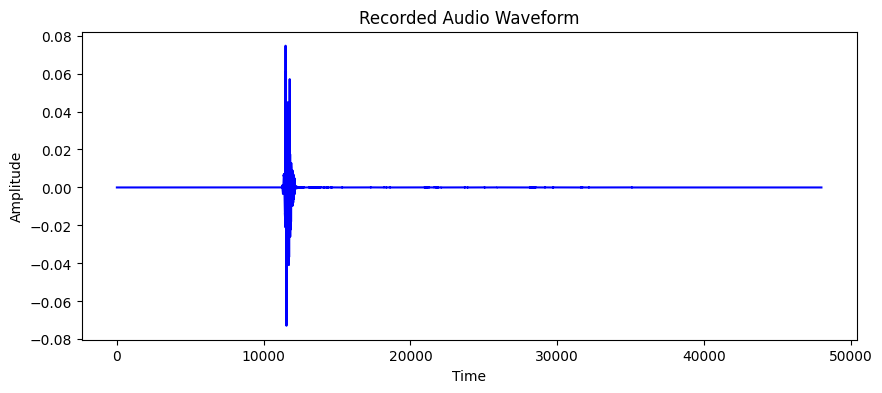

🔊 Playing recorded audio...


In [10]:
# Record audio with silence detection
audio_data = record_audio_until_silence()

# 🔹 Testing: Plot waveform of recorded audio
if audio_data is not None and len(audio_data) > 0:
    plt.figure(figsize=(10, 4))
    plt.plot(audio_data, color="blue")
    plt.title("Recorded Audio Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    # 🔹 Optional: Listen to the recorded audio
    import soundfile as sf
    import io
    from IPython.display import Audio

    # Save to a buffer and play it
    wav_buffer = io.BytesIO()
    sf.write(wav_buffer, audio_data, SAMPLE_RATE, format='WAV')
    wav_buffer.seek(0)

    print("🔊 Playing recorded audio...")
    display(Audio(wav_buffer.read(), rate=SAMPLE_RATE))
else:
    print("⚠️ No audio recorded. Try speaking louder.")

## Step 2: Speech to Text

In [11]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load Whisper processor & model from Hugging Face
stt_model_name = "openai/whisper-small"
stt_processor = WhisperProcessor.from_pretrained(stt_model_name)
stt_model = WhisperForConditionalGeneration.from_pretrained(stt_model_name)

# Ensure the model doesn't force a specific language
stt_model.config.forced_decoder_ids = None  

print("✅ Hugging Face Whisper Model Loaded Successfully")

✅ Hugging Face Whisper Model Loaded Successfully


In [12]:
import soundfile as sf
import io
import torch

def transcribe_audio(audio_data, sample_rate=16000):
    print("⏳ Transcribing speech...")

    # Process the NumPy audio array directly (no need to convert to WAV)
    input_features = stt_processor(audio_data, sampling_rate=sample_rate, return_tensors="pt").input_features 

    # Generate transcription
    with torch.no_grad():
        predicted_ids = stt_model.generate(input_features)

    # Decode token IDs into text
    transcription = stt_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    print(f"✅ Transcription: {transcription}")
    return transcription  # Return transcribed text

# Run transcription on recorded audio
transcribed_text = transcribe_audio(audio_data)
print("📝 Final Transcribed Text:", transcribed_text)


⏳ Transcribing speech...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Transcription:  you
📝 Final Transcribed Text:  you


## Step 3: Classify the intent based on user input:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
intent_model_name = "Falconsai/intent_classification"
intent_tokenizer = AutoTokenizer.from_pretrained(intent_model_name)
intent_model = AutoModelForSequenceClassification.from_pretrained(intent_model_name)

print("✅ Intent Classification Model Loaded Successfully!")

In [ ]:
def classify_intent(text):
    print("🔍 Classifying Intent...")

    # Tokenize the input text
    inputs = intent_tokenizer(text, return_tensors="pt")

    # Get model predictions
    with torch.no_grad():
        outputs = intent_model(**inputs)

    # Get the predicted intent label
    predicted_id = torch.argmax(outputs.logits, dim=-1).item()
    detected_intent = intent_model.config.id2label[predicted_id]

    return detected_intent


In [ ]:
detected_intent = classify_intent(transcribed_text)
print("🎯 Transcribed text:", transcribed_text)
print("🎯 Final Intent:", detected_intent)


🔍 Classifying Intent...
✅ Detected Intent: edit account
🎯 Transcribed text:  Can you recommend the best laptop for gaming?
🎯 Final Intent: edit account


## Model is not performing, let's use another model and test for sample inputs.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load the tokenizer and model
an_intent_model_name = "Serj/intent-classifier"
an_intent_tokenizer = AutoTokenizer.from_pretrained(an_intent_model_name)
an_intent_model = AutoModelForSeq2SeqLM.from_pretrained(an_intent_model_name)

print("✅ 'Serj/intent-classifier' Model Loaded Successfully!")

✅ 'Serj/intent-classifier' Model Loaded Successfully!


In [ ]:
# Few-shot examples provided in the prompt

few_shot_prompt = """\
Customer: I want to buy a new phone.
Intent: Shopping

Customer: How do I pay my electricity bill?
Intent: Bill Payment

Customer: My internet is not working properly.
Intent: Technical Issue

Customer: I need help resetting my bank password.
Intent: Customer Support

Customer: Can you recommend the best laptop for gaming?
Intent: Shopping

Customer: I was trying to make a payment, but I keep getting a 'Payment not authorized' error. 
Intent: Billing Issue

Customer: I received the wrong product and need to return it for a refund.
Intent: Returns & Refunds

Customer: My internet is not working properly and keeps disconnecting frequently.
Intent: Technical Issue

Customer: I am looking to upgrade my phone to the latest model and need advice on the best option.
Intent: Product Inquiry

Customer: I need help resetting my password for my online banking account.
Intent: Customer Support

Customer: I want to track my order that was supposed to be delivered yesterday.
Intent: Delivery / Order Tracking

Customer: I need to change my shipping address for an order I placed yesterday.
Intent: Order Modification

Customer: I am considering subscribing to your premium plan but want to understand the differences between the Basic and Premium plans.
Intent: Subscription Inquiry

Customer: {} 
Intent:"""


# 🔹 Function to Classify User Intent in Real-Time Using Few-Shot Learning
def classify_intent_few_shot(user_input):
    print("🔍 Classifying Intent...")

    # Format the input text with few-shot examples
    formatted_input = few_shot_prompt.format(user_input)

    # Tokenize the input
    inputs = an_intent_tokenizer(formatted_input, return_tensors="pt", max_length=512, truncation=True)

    # Get model predictions
    with torch.no_grad():
        outputs = an_intent_model.generate(**inputs)

    # Decode the generated response
    detected_intent = an_intent_tokenizer.decode(outputs[0], skip_special_tokens=True)

    return detected_intent

In [ ]:
sample_text = """I was trying to purchase a laptop on your website, but when I added it to the cart and proceeded to payment, 
the system kept giving me an error saying 'Payment not authorized'. I tried two different credit cards, 
but I’m still facing the same issue. Can you please help me complete my order?"""

detected_intent = classify_intent_few_shot(sample_text)
print("🎯 Transcribed text:", sample_text)
print("🎯 Final Intent:", detected_intent)

🔍 Classifying Intent...
🎯 Transcribed text: I was trying to purchase a laptop on your website, but when I added it to the cart and proceeded to payment, 
the system kept giving me an error saying 'Payment not authorized'. I tried two different credit cards, 
but I’m still facing the same issue. Can you please help me complete my order?
🎯 Final Intent: Order Status


In [ ]:
test_sentences = [
    """I was trying to purchase a laptop on your website, but when I added it to the cart and proceeded to payment, 
    the system kept giving me an error saying 'Payment not authorized'. I tried two different credit cards, 
    but I’m still facing the same issue. Can you please help me complete my order?""",

    """Yesterday, I received a package from your store, but when I opened it, I found that the item inside was not what 
    I ordered. I had requested a wireless headset, but I got a wired one instead. I need to return this and get a refund. 
    Can you assist me with the process?""",

    """I have been experiencing frequent internet disconnections at my home for the past two weeks. The connection drops randomly, 
    and I have to restart my router multiple times a day. This has been affecting my work. Could you send a technician to check my connection?""",

    """I am considering upgrading my phone to the latest iPhone 15 Pro, but I am unsure whether I should get the Pro or Pro Max model. 
    I mainly use my phone for photography, gaming, and streaming videos. Can you help me decide which model is the best for my needs?""",

    """I subscribed to your premium service last month, but I no longer need it. I would like to cancel my subscription before the 
    next billing cycle. Please guide me through the cancellation process so that I don’t get charged again.""",
]

# Test Intent Classification for Each Sentence
for sentence in test_sentences:
    print(f"\n🗣️ User: {sentence}")
    detected_intent = classify_intent_few_shot(sentence)
    print(f"🎯 Detected Intent: {detected_intent}\n")



🗣️ User: I was trying to purchase a laptop on your website, but when I added it to the cart and proceeded to payment, 
    the system kept giving me an error saying 'Payment not authorized'. I tried two different credit cards, 
    but I’m still facing the same issue. Can you please help me complete my order?
🔍 Classifying Intent...
🎯 Detected Intent: Order Status


🗣️ User: Yesterday, I received a package from your store, but when I opened it, I found that the item inside was not what 
    I ordered. I had requested a wireless headset, but I got a wired one instead. I need to return this and get a refund. 
    Can you assist me with the process?
🔍 Classifying Intent...
🎯 Detected Intent: Returns & Refunds


🗣️ User: I have been experiencing frequent internet disconnections at my home for the past two weeks. The connection drops randomly, 
    and I have to restart my router multiple times a day. This has been affecting my work. Could you send a technician to check my connection?
🔍 Cl

In [ ]:
test_sentences = [
    """I ordered a smartwatch last week, and it was supposed to be delivered yesterday. 
    However, I haven’t received any tracking updates, and the package is still marked as 'Processing'. 
    Can you check the status of my delivery?""",

    """I am thinking about subscribing to your premium plan, but I want to know the differences between the Basic 
    and Premium plans. What are the extra benefits I get with the Premium plan?""",

    """My mobile app keeps crashing every time I try to open it. I have already tried reinstalling it, 
    but the issue persists. Could you help me troubleshoot this?""",

    """I need to change my shipping address for an order I placed yesterday. 
    I accidentally entered the wrong address, and I want to make sure my package is sent to the correct location.""",

    """I just got my electricity bill, and the amount seems much higher than usual. 
    Can you help me understand why my bill is so high and if there were any incorrect charges?""",

    """I want to delete my account permanently. I no longer wish to use your services, 
    and I need instructions on how to remove my personal data from your platform.""",
]

# Run classification on each sentence
for sentence in test_sentences:
    print(f"\n🗣️ User: {sentence}")
    detected_intent = classify_intent_few_shot(sentence)
    print(f"🎯 Detected Intent: {detected_intent}\n")



🗣️ User: I ordered a smartwatch last week, and it was supposed to be delivered yesterday. 
    However, I haven’t received any tracking updates, and the package is still marked as 'Processing'. 
    Can you check the status of my delivery?
🔍 Classifying Intent...
🎯 Detected Intent: Delivery / Order Tracking


🗣️ User: I am thinking about subscribing to your premium plan, but I want to know the differences between the Basic 
    and Premium plans. What are the extra benefits I get with the Premium plan?
🔍 Classifying Intent...
🎯 Detected Intent: Subscription Inquiry


🗣️ User: My mobile app keeps crashing every time I try to open it. I have already tried reinstalling it, 
    but the issue persists. Could you help me troubleshoot this?
🔍 Classifying Intent...
🎯 Detected Intent: Technical Issue


🗣️ User: I need to change my shipping address for an order I placed yesterday. 
    I accidentally entered the wrong address, and I want to make sure my package is sent to the correct location.

# Here is the final code that works more accurate

## Step 1: Capture User Voice Input

In [ ]:
import sounddevice as sd
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt

# Audio Settings
SAMPLE_RATE = 16000  # Standard speech recognition sample rate
SILENCE_THRESHOLD = 0.01  # Silence detection threshold (adjustable)
SILENCE_DURATION = 2  # Stop recording if silence lasts this long (seconds)

def record_audio_until_silence(sample_rate=SAMPLE_RATE, silence_threshold=SILENCE_THRESHOLD, silence_duration=SILENCE_DURATION):
    print("🎤 Listening... Speak now (Stops when silent for 2 seconds)...")

    audio_buffer = []
    silence_start = None
    stream = sd.InputStream(samplerate=sample_rate, channels=1, dtype=np.float32)
    
    with stream:
        while True:
            # Read audio chunk
            audio_chunk, _ = stream.read(int(sample_rate * 0.1))  # 100ms chunks
            audio_buffer.append(audio_chunk)

            # Compute volume level
            volume_level = np.max(np.abs(audio_chunk))

            # Check for silence
            if volume_level < silence_threshold:
                if silence_start is None:
                    silence_start = time.time()
                elif time.time() - silence_start >= silence_duration:
                    print("🛑 Silence detected! Stopping recording.")
                    break
            else:
                silence_start = None  # Reset silence detection if user speaks

    # Convert list of chunks to NumPy array
    recorded_audio = np.concatenate(audio_buffer, axis=0).flatten()

    print("✅ Recording complete.")
    return recorded_audio  # Return raw audio for next step

🎤 Listening... Speak now (Stops when silent for 3 seconds)...
🛑 Silence detected! Stopping recording.
✅ Recording complete.


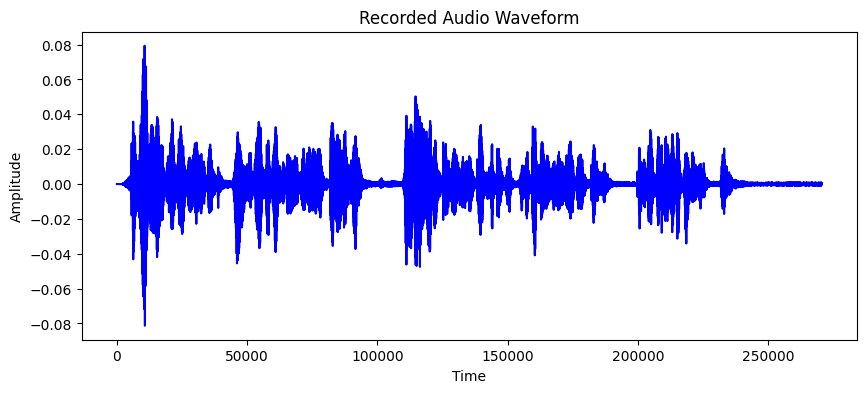

🔊 Playing recorded audio...


In [ ]:
# Record audio with silence detection
audio_data = record_audio_until_silence()

# 🔹 Testing: Plot waveform of recorded audio
if audio_data is not None and len(audio_data) > 0:
    plt.figure(figsize=(10, 4))
    plt.plot(audio_data, color="blue")
    plt.title("Recorded Audio Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    # 🔹 Optional: Listen to the recorded audio
    import soundfile as sf
    import io
    from IPython.display import Audio

    # Save to a buffer and play it
    wav_buffer = io.BytesIO()
    sf.write(wav_buffer, audio_data, SAMPLE_RATE, format='WAV')
    wav_buffer.seek(0)

    print("🔊 Playing recorded audio...")
    display(Audio(wav_buffer.read(), rate=SAMPLE_RATE))
else:
    print("⚠️ No audio recorded. Try speaking louder.")

## Step 2: Convert Speech to Text (STT) using Whisper

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load Whisper processor & model from Hugging Face
stt_model_name = "openai/whisper-small"
stt_processor = WhisperProcessor.from_pretrained(stt_model_name)
stt_model = WhisperForConditionalGeneration.from_pretrained(stt_model_name)

# Ensure the model doesn't force a specific language
stt_model.config.forced_decoder_ids = None  

print("✅ Hugging Face Whisper Model Loaded Successfully")

In [ ]:
# Convert Recorded Audio & Transcribe Speech

import soundfile as sf
import io
import torch

def transcribe_audio(audio_data, sample_rate=16000):
    print("⏳ Transcribing speech...")

    # Process the NumPy audio array directly (no need to convert to WAV)
    input_features = stt_processor(audio_data, sampling_rate=sample_rate, return_tensors="pt").input_features 

    # Generate transcription
    with torch.no_grad():
        predicted_ids = stt_model.generate(input_features)

    # Decode token IDs into text
    transcription = stt_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    return transcription  # Return transcribed text

In [ ]:
# Run transcription on recorded audio
transcribed_text = transcribe_audio(audio_data)
print("📝 Final Transcribed Text:", transcribed_text)

⏳ Transcribing speech...
📝 Final Transcribed Text:  I ordered a smartwatch last week and it was supposed to be a delivery word yesterday. However, I haven't received any tracking updates and the package is still marked as processing. Can you check the status of my delivery please?


## Step 3: Intent Classification using Serj/intent-classifier using some few shot examples for better response

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load the tokenizer and model
an_intent_model_name = "Serj/intent-classifier"
an_intent_tokenizer = AutoTokenizer.from_pretrained(an_intent_model_name)
an_intent_model = AutoModelForSeq2SeqLM.from_pretrained(an_intent_model_name)

print("✅ 'Serj/intent-classifier' Model Loaded Successfully!")

In [ ]:
# Few-shot examples provided in the prompt

few_shot_prompt = """\
Customer: I want to buy a new phone.
Intent: Shopping

Customer: How do I pay my electricity bill?
Intent: Bill Payment

Customer: My internet is not working properly.
Intent: Technical Issue

Customer: I need help resetting my bank password.
Intent: Customer Support

Customer: Can you recommend the best laptop for gaming?
Intent: Shopping

Customer: I was trying to make a payment, but I keep getting a 'Payment not authorized' error. 
Intent: Billing Issue

Customer: I received the wrong product and need to return it for a refund.
Intent: Returns & Refunds

Customer: My internet is not working properly and keeps disconnecting frequently.
Intent: Technical Issue

Customer: I am looking to upgrade my phone to the latest model and need advice on the best option.
Intent: Product Inquiry

Customer: I need help resetting my password for my online banking account.
Intent: Customer Support

Customer: I want to track my order that was supposed to be delivered yesterday.
Intent: Delivery / Order Tracking

Customer: I need to change my shipping address for an order I placed yesterday.
Intent: Order Modification

Customer: I am considering subscribing to your premium plan but want to understand the differences between the Basic and Premium plans.
Intent: Subscription Inquiry

Customer: {} 
Intent:"""

In [ ]:
# Function to Classify User Intent in Real-Time Using Few-Shot Learning
def classify_intent_few_shot(user_input):
    print("🔍 Classifying Intent...")

    # Format the input text with few-shot examples
    formatted_input = few_shot_prompt.format(user_input)

    # Tokenize the input
    inputs = an_intent_tokenizer(formatted_input, return_tensors="pt", max_length=512, truncation=True)

    # Get model predictions
    with torch.no_grad():
        outputs = an_intent_model.generate(**inputs)

    # Decode the generated response
    detected_intent = an_intent_tokenizer.decode(outputs[0], skip_special_tokens=True)

    return detected_intent

In [ ]:
detected_intent = classify_intent_few_shot(transcribed_text)
print("🎯 Transcribed text:", transcribed_text)
print("🎯 Final Intent:", detected_intent)

🔍 Classifying Intent...


🎯 Transcribed text:  I ordered a smartwatch last week and it was supposed to be a delivery word yesterday. However, I haven't received any tracking updates and the package is still marked as processing. Can you check the status of my delivery please?
🎯 Final Intent: Delivery / Order Tracking
